In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
import sklearn.ensemble
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.metrics import average_precision_score, precision_recall_curve, confusion_matrix
from inspect import signature

from sklearn.preprocessing import label_binarize

from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm
from scipy import interp
from itertools import cycle

### Load the Training Data

In [2]:
inputData = pd.read_csv('trainData_set1.csv')

#### Replace Upcylce and Downcycle to Up and Down in the Indicative Tick Direction Column

In [3]:
inputData.TICKDIR.describe()

count     52396
unique        5
top        FLAT
freq      47029
Name: TICKDIR, dtype: object

In [4]:
subset = inputData.groupby(by='TICKDIR')['TIME'].count()
subset

TICKDIR
DOWN          1685
DOWNCYCLE     1163
FLAT         47029
UP            1665
UPCYCLE        854
Name: TIME, dtype: int64

In [5]:
inputData['TICKDIR'] = inputData.TICKDIR.str.replace('UPCYCLE', 'UP')
inputData['TICKDIR'] = inputData.TICKDIR.str.replace('DOWNCYCLE', 'DOWN')

In [6]:
subset = inputData.groupby(by='TICKDIR')['TIME'].count()
subset

TICKDIR
DOWN     2848
FLAT    47029
UP       2519
Name: TIME, dtype: int64

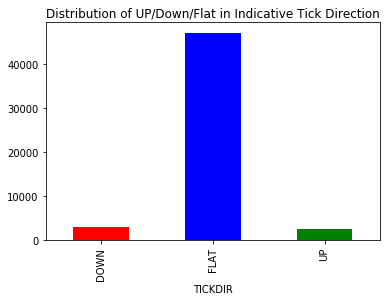

In [7]:
subset.plot(kind='bar', title='Distribution of UP/Down/Flat in Indicative Tick Direction',
           color=['red','blue','green']);

#### Extract a single feature - bid ask imbalance

In [8]:
# extracting a single feature
X = inputData.BIDASKIMBALANCE

#### Reshaping X as it has only one feature

In [70]:
X = np.array(X).reshape(-1,1)

In [71]:
X.shape

(52396, 1)

### Multi Classification 

#### Converting the Indicative Tick Direction to numerical format

In [68]:
y = inputData.TICKDIR.replace('UP', 2)
y = y.replace('FLAT', 0)
y = y.replace('DOWN', 1)

In [69]:
y.shape

(52396,)

#### Binarize the output

In [88]:
y = label_binarize(y, classes=[0,1,2])

In [89]:
n_classes = y.shape[1]

In [90]:
n_classes

3

#### Train test split

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)

#### Learn to predict each class against the other

In [94]:
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=0))

In [92]:
classifier = sklearn.ensemble.GradientBoostingClassifier(n_estimators=500)

In [95]:
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

#### Compute ROC curve and ROC area for each class

In [96]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#### Compute micro-average ROC curve and ROC area

In [97]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#### Plot ROC curves for the multiclass problem

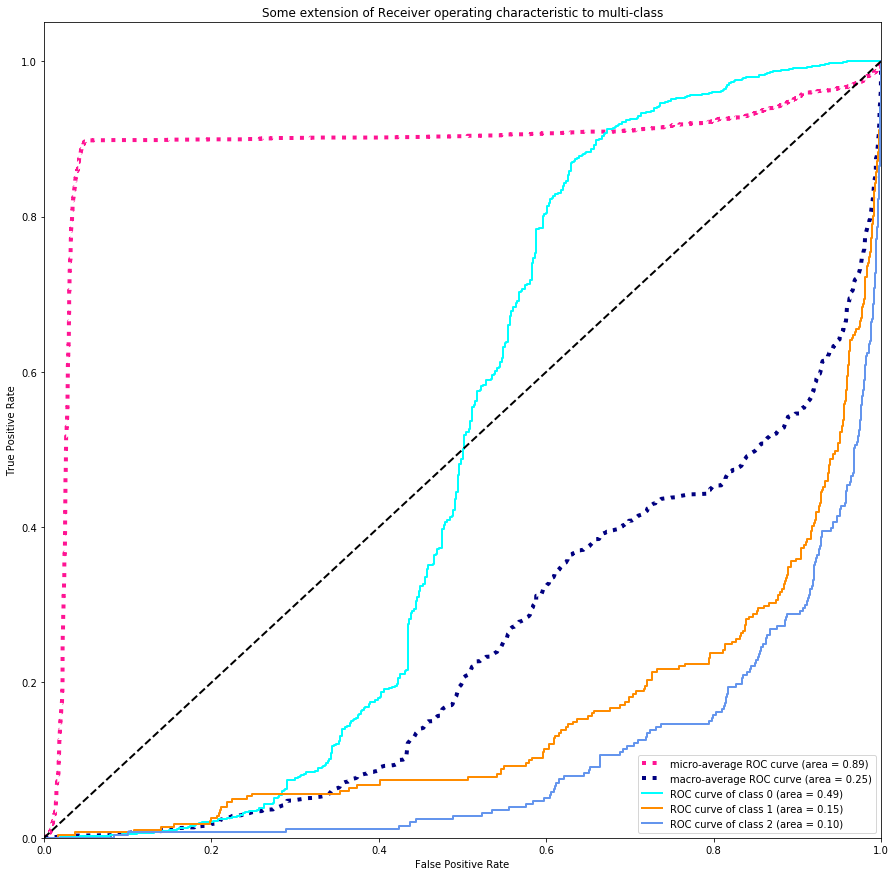

In [98]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.figure(figsize=(15,15))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show();

#### Classifying by Random Forest and Gradient Boosting

In [81]:
gb = sklearn.ensemble.GradientBoostingClassifier(n_estimators=500)
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)

In [82]:
y_score = gb.fit(X_train, y_train)

In [83]:
y_score = gb.predict_proba(X_test)

In [84]:
y_score = y_score[:,1]

#### ROC AUC Score and Plot

In [227]:
converted_local = [x > 0.5 for x in y_score]

In [193]:
converted_local[0:5]

[False, True, False, True, True]

In [25]:
y_score[0:5]

array([[0.02171547, 0.9769699 , 0.00131463],
       [0.00389487, 0.92480113, 0.071304  ],
       [0.03085646, 0.96789268, 0.00125086],
       [0.00298939, 0.89546352, 0.10154709],
       [0.01431829, 0.94315074, 0.04253097]])

In [85]:
converted_local = y_score

In [86]:
roc_auc_score(y_test, converted_local)

ValueError: multiclass format is not supported

In [229]:
converted_dummies = pd.get_dummies(converted_local)

In [230]:
converted_dummies.shape

(5240, 2)

In [231]:
y_test_dummies = pd.get_dummies(y_test)
y_test_dummies.shape

(5240, 2)

In [232]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[i], converted_dummies[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

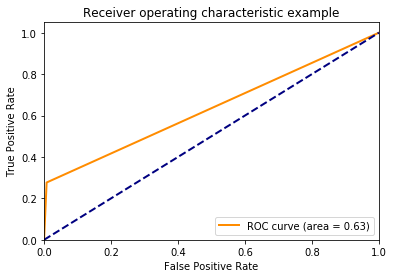

In [233]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### Accuracy Score and Precision-recall Curve

In [16]:
y_pred = gb.predict(X_test)

In [80]:
accuracy_score(y_test, y_pred)

ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

In [234]:
converted_local = [x > 0.05 for x in y_score]

In [235]:
accuracy_score(y_test, converted_local)

0.8446564885496183

In [104]:
y_score = gb.predict_proba(X_test)
y_score = y_score[:,1]

In [125]:
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.49


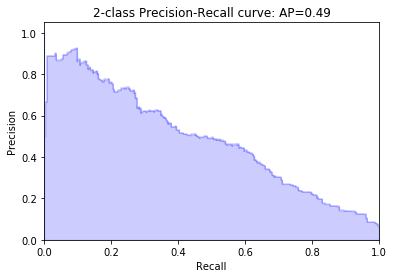

In [126]:
precision, recall, _ = precision_recall_curve(y_test, y_score)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision));

In [138]:
converted_local = [x > 0.25 for x in y_score]

In [139]:
average_precision = average_precision_score(y_test, converted_local)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.27


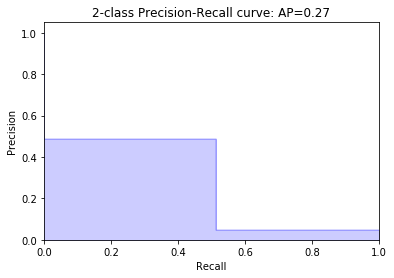

In [140]:
precision, recall, _ = precision_recall_curve(y_test, converted_local)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision));

#### Confusion Matrix

In [54]:
y_pred = classifier.predict(X_test)

In [55]:
confusion_matrix(y_test, y_pred)

ValueError: multilabel-indicator is not supported

In [241]:
confusion_matrix(y_test, converted_local)

array([[4949,   38],
       [ 183,   70]])